# 模型安全

## 概述

本次体验流程介绍MindArmour提供的模型安全防护手段，引导您快速使用MindArmour，为您的AI模型提供一定的安全防护能力。

AI算法设计之初普遍未考虑相关的安全威胁，使得AI算法的判断结果容易被恶意攻击者影响，导致AI系统判断失准。攻击者在原始样本处加入人类不易察觉的微小扰动，导致深度学习模型误判，称为对抗样本攻击。MindArmour模型安全提供对抗样本生成、对抗样本检测、模型防御、攻防效果评估等功能，为AI模型安全研究和AI应用安全提供重要支撑。

- 对抗样本生成模块支持安全工程师快速高效地生成对抗样本，用于攻击AI模型。
- 对抗样本检测、防御模块支持用户检测过滤对抗样本、增强AI模型对于对抗样本的鲁棒性。
- 评估模块提供多种指标全面评估对抗样本攻防性能。

接下来通过图像分类任务上的对抗性攻防，以攻击算法FGSM和防御算法NAD为例，体验MindArmour在对抗攻防上的使用方法。

## 整体流程

1. 准备环节。下载MNIST数据集，配置运行信息和数据处理。
2. 预训练模型。定义LeNet5网络，训练模型，生成CheckPoint文件。
3. 建立被攻击模型。加载预训练模型，测试模型精度，攻击模型，测试攻击后模型精度。
4. 对抗性防御。防御实现和防御效果分析。

> 本次体验流程支持硬件平台为：
> - CPU：在配置运行信息环节配置`context.set_context`中的`device_target`参数为`device_target="CPU"`（本次体验默认使用CPU硬件平台）。
> - GPU：在配置运行信息环节配置`context.set_context`中的`device_target`参数为`device_target="GPU"`。
> - Ascend：在配置运行信息环节配置`context.set_context`中的`device_target`参数为`device_target="Ascend"`。

## 准备环节

###  下载数据集

本次体验使用MNIST数据集，运行以下一段代码下载MNIST数据集并解压到当前工作目录下的`./datasets/MNIST_Data/`目录里。

> MNIST数据集下载地址为：<https://mindspore-website.obs.myhuaweicloud.com/notebook/datasets/MNIST_Data.zip>。

In [1]:
!wget https://mindspore-website.obs.myhuaweicloud.com/notebook/datasets/MNIST_Data.zip -N
!unzip -o MNIST_Data.zip -d datasets

--2020-12-01 16:52:49--  https://mindspore-website.obs.myhuaweicloud.com/notebook/datasets/MNIST_Data.zip
Resolving proxy-notebook.modelarts-dev-proxy.com (proxy-notebook.modelarts-dev-proxy.com)... 192.168.0.172
Connecting to proxy-notebook.modelarts-dev-proxy.com (proxy-notebook.modelarts-dev-proxy.com)|192.168.0.172|:8083... connected.
Proxy request sent, awaiting response... 200 OK
Length: 10754903 (10M) [application/zip]
Saving to: ‘MNIST_Data.zip’

MNIST_Data.zip      100%[===================>]  10.26M  --.-KB/s    in 0.05s   

2020-12-01 16:52:49 (188 MB/s) - ‘MNIST_Data.zip’ saved [10754903/10754903]

Archive:  MNIST_Data.zip
   creating: datasets/MNIST_Data/test/
  inflating: datasets/MNIST_Data/test/t10k-images-idx3-ubyte  
  inflating: datasets/MNIST_Data/test/t10k-labels-idx1-ubyte  
   creating: datasets/MNIST_Data/train/
  inflating: datasets/MNIST_Data/train/train-images-idx3-ubyte  
  inflating: datasets/MNIST_Data/train/train-labels-idx1-ubyte  


MNIST数据集下载完成后，查看此时当前工作目录下`datasets`目录结构。

In [2]:
!tree -L 3 datasets

datasets
└── MNIST_Data
    ├── test
    │   ├── t10k-images-idx3-ubyte
    │   └── t10k-labels-idx1-ubyte
    └── train
        ├── train-images-idx3-ubyte
        └── train-labels-idx1-ubyte

3 directories, 4 files


其中：
- `t10k-images-idx3-ubyte`为测试图像数据文件。
- `t10k-labels-idx1-ubyte`为测试图像标签文件。
- `train-images-idx3-ubyte`为训练图像数据文件。
- `train-labels-idx1-ubyte`为训练图像标签文件。

### 配置运行信息


运行以下两段代码配置运行环境。其中：
- `device_target`：指定运行环境，本次体验流程基于CPU环境，配置`device_target="CPU"`。
- `set_level`：指定LOGGER输出等级，此处配置为`LOGGER.set_level(1)`。


In [3]:
import mindspore

msversion  = mindspore.__version__
print("Current version of MindSpore installed is:", msversion)
masource = "https://ms-release.obs.cn-north-4.myhuaweicloud.com/{0}/MindArmour/x86_64/mindarmour-{0}-cp37-cp37m-linux_x86_64.whl".format(msversion)
!pip install $masource

Current version of MindSpore installed is: 1.0.1
Looking in indexes: http://repo.myhuaweicloud.com/repository/pypi/simple
     |████████████████████████████████| 223 kB 77.4 MB/s eta 0:00:01


In [4]:
from mindspore import context
from mindarmour.utils.logger import LogUtil

context.set_context(mode=context.GRAPH_MODE, device_target="CPU")
LOGGER = LogUtil.get_instance()
LOGGER.set_level(1)

print("The current env loaded: \n    mode: {}\n    device_target: {}".format(context.get_context("mode"), context.get_context("device_target")))

The current env loaded: 
    mode: 0
    device_target: CPU


### 数据处理

利用MindSpore的`dataset`模块提供的`MnistDataset`接口加载MNIST数据集，定义函数`generate_mnist_dataset`对原始数据进行预处理操作，以创建可用于训练和测试的数据集。利用数据加载函数`generate_mnist_dataset`载入数据生成训练数据集`ds_train`和测试数据集`ds_test`，并打印数据集`ds_train`第一组共32张训练图像信息。

The 32 images with label of the first batch in ds_train are showed below:


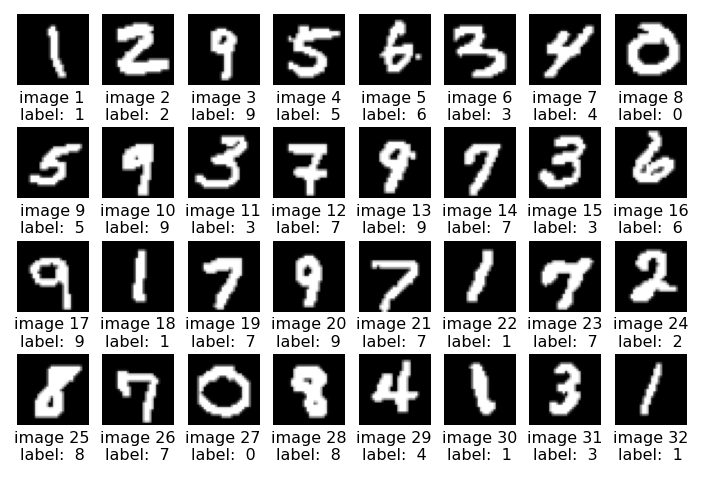

In [5]:
import mindspore.dataset as ds
import numpy as np
import mindspore.dataset.vision.c_transforms as CV
import mindspore.dataset.transforms.c_transforms as C
from mindspore.dataset.vision import Inter
from mindspore import dtype as mstype
from matplotlib import pyplot as plt

# generate testing data
def generate_mnist_dataset(data_path, batch_size=32, repeat_size=1,
                           num_parallel_workers=1, sparse=True):
    """
    create dataset for training or testing
    """
    # define dataset
    ds1 = ds.MnistDataset(data_path)

    # define operation parameters
    resize_height, resize_width = 32, 32
    rescale = 1.0 / 255.0
    shift = 0.0

    # define map operations
    resize_op = CV.Resize((resize_height, resize_width),
                          interpolation=Inter.LINEAR)
    rescale_op = CV.Rescale(rescale, shift)
    hwc2chw_op = CV.HWC2CHW()
    type_cast_op = C.TypeCast(mstype.int32)

    # apply map operations on images
    if not sparse:
        one_hot_enco = C.OneHot(10)
        ds1 = ds1.map(operations=one_hot_enco, input_columns="label",
                      num_parallel_workers=num_parallel_workers)
        type_cast_op = C.TypeCast(mstype.float32)
    ds1 = ds1.map(operations=type_cast_op, input_columns="label",
                  num_parallel_workers=num_parallel_workers)
    ds1 = ds1.map(operations=resize_op, input_columns="image",
                  num_parallel_workers=num_parallel_workers)
    ds1 = ds1.map(operations=rescale_op,input_columns="image",
                  num_parallel_workers=num_parallel_workers)
    ds1 = ds1.map(operations=hwc2chw_op, input_columns="image",
                  num_parallel_workers=num_parallel_workers)

    # apply DatasetOps
    buffer_size = 10000
    ds1 = ds1.shuffle(buffer_size=buffer_size)
    ds1 = ds1.batch(batch_size, drop_remainder=True)
    ds1 = ds1.repeat(repeat_size)

    return ds1

batch_size = 32
ds_train = generate_mnist_dataset("./datasets/MNIST_Data/train/")
ds_test = generate_mnist_dataset("./datasets/MNIST_Data/test/", batch_size=batch_size, sparse=False)

print("The 32 images with label of the first batch in ds_train are showed below:")
ds_iterator = ds_train.create_dict_iterator()
ds_iterator.get_next()
batch_1 = ds_iterator.get_next()
batch_image = batch_1["image"].asnumpy()
batch_label = batch_1["label"].asnumpy()
%matplotlib inline
plt.figure(dpi=144)
for i,image in enumerate(batch_image):
    plt.subplot(4, 8, i+1)
    plt.subplots_adjust(wspace=0.2, hspace=0.2)
    image = np.squeeze(image, 0)
    image = image/np.amax(image)
    image = np.clip(image, 0, 1)
    plt.imshow(image, cmap="gray")
    plt.title(f"image {i+1}\nlabel:  {batch_label[i]}", y=-0.65, fontdict={"fontsize":8})
    plt.axis('off')    
plt.show()

## 预训练模型

本次流程以LeNet5模型为例。运行以下一段代码，定义LeNet5网络模型，训练模型并保存CheckPoint文件。

In [6]:
import os
import mindspore.nn as nn
from mindspore.common.initializer import TruncatedNormal
from mindspore.train.callback import ModelCheckpoint, CheckpointConfig, LossMonitor, TimeMonitor
from mindspore import Model
from mindspore.nn.metrics import Accuracy

def conv(in_channels, out_channels, kernel_size, stride=1, padding=0):
    weight = weight_variable()
    return nn.Conv2d(in_channels, out_channels,
                     kernel_size=kernel_size, stride=stride, padding=padding,
                     weight_init=weight, has_bias=False, pad_mode="valid")


def fc_with_initialize(input_channels, out_channels):
    weight = weight_variable()
    bias = weight_variable()
    return nn.Dense(input_channels, out_channels, weight, bias)


def weight_variable():
    return TruncatedNormal(0.02)


class LeNet5(nn.Cell):
    """
    Lenet network
    """
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = conv(1, 6, 5)
        self.conv2 = conv(6, 16, 5)
        self.fc1 = fc_with_initialize(16*5*5, 120)
        self.fc2 = fc_with_initialize(120, 84)
        self.fc3 = fc_with_initialize(84, 10)
        self.relu = nn.ReLU()
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()

    def construct(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

lr = 0.01
momentum = 0.9
network = LeNet5()
model_path = "./ckpt"
# clean old run files in linux
os.system('rm -f {0}*.ckpt {0}*.meta {0}*.pb'.format(model_path))

net_loss = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction="mean")
net_opt = nn.Momentum(network.trainable_params(), lr, momentum)
time_cb = TimeMonitor(data_size=ds_train.get_dataset_size())
config_ck = CheckpointConfig(save_checkpoint_steps=1875,
                             keep_checkpoint_max=10)
ckpoint_cb = ModelCheckpoint(prefix="checkpoint_lenet", directory=model_path, config=config_ck)
model = Model(network, net_loss, net_opt, metrics={"Accuracy": Accuracy()})

print("============== Starting Training ==============")
model.train(epoch=10, train_dataset=ds_train, callbacks=[time_cb, ckpoint_cb, LossMonitor(per_print_times=375)],
                dataset_sink_mode=False)


============== Starting Training ==============
epoch: 1 step: 375, loss is 2.2983687
epoch: 1 step: 750, loss is 2.3185787
epoch: 1 step: 1125, loss is 2.2873642
epoch: 1 step: 1500, loss is 2.3000097
epoch: 1 step: 1875, loss is 2.2676728
Epoch time: 19415.527, per step time: 10.355
epoch: 2 step: 375, loss is 1.8463521
epoch: 2 step: 750, loss is 0.30592605
epoch: 2 step: 1125, loss is 0.13993229
epoch: 2 step: 1500, loss is 0.33774194
epoch: 2 step: 1875, loss is 0.06339652
Epoch time: 18092.739, per step time: 9.649
epoch: 3 step: 375, loss is 0.22111271
epoch: 3 step: 750, loss is 0.028834635
epoch: 3 step: 1125, loss is 0.018264536
epoch: 3 step: 1500, loss is 0.137757
epoch: 3 step: 1875, loss is 0.03770245
Epoch time: 17978.534, per step time: 9.589
epoch: 4 step: 375, loss is 0.20166841
epoch: 4 step: 750, loss is 0.08258131
epoch: 4 step: 1125, loss is 0.006526878
epoch: 4 step: 1500, loss is 0.048344947
epoch: 4 step: 1875, loss is 0.031841453
Epoch time: 17969.653, per ste

## 建立被攻击模型

以MNIST为示范数据集，自定义的简单模型LeNet5网络模型作为被攻击模型。

### 加载LeNet模型文件

运行以下一段代码，加载预训练的LeNet模型文件（`checkpoint_lenet-10_1875.ckpt`），并打印输出网络中载入的所有的参数名。

In [7]:
from mindspore.train.serialization import load_checkpoint, load_param_into_net


ckpt_name = './ckpt/checkpoint_lenet-10_1875.ckpt'
net = LeNet5()
load_dict = load_checkpoint(ckpt_name)
load_param_into_net(net, load_dict)

# get all names of parameters in net.
h = network.parameters_dict(recurse=True)
print("The names of all params are: ", [i for i in h.keys()])

The names of all params are:  ['conv1.weight', 'conv2.weight', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias']


### 测试攻击前模型精度

从训练数据集`ds_test`中抽取前3组共96张数据图像和标签用于测试预训练模型精度。运行以下一段代码，测试预训练模型对被攻击之前的测试图像进行预测的精度。通过输出INFO信息可以看到，测试结果中分类精度达到了97.9%。

In [8]:
from mindspore import Tensor


# prediction accuracy before attack
TAG = 'demo'
model = Model(net)
batch_num = 3  # the number of batches of attacking samples
test_images = []
test_labels = []
predict_labels = []
i = 0
for data in ds_test.create_tuple_iterator():
    i += 1
    images = data[0].asnumpy().astype(np.float32)
    labels = data[1].asnumpy()
    test_images.append(images)
    test_labels.append(labels)
    pred_labels = np.argmax(model.predict(Tensor(images)).asnumpy(),
                            axis=1)
    predict_labels.append(pred_labels)
    if i >= batch_num:
        break
predict_labels = np.concatenate(predict_labels)
true_labels = np.argmax(np.concatenate(test_labels), axis=1)
accuracy = np.mean(np.equal(predict_labels, true_labels))
LOGGER.info(TAG, "prediction accuracy before attacking is : %s", accuracy)

[INFO] MA(2622:139980130522944,MainProcess):2020-12-01 16:56:11,287 [<ipython-input-8-2ca8b2dce53a>:26] [demo] prediction accuracy before attacking is : 0.9791666666666666


运行以下一段代码，打印测试数据图像信息。

Test images before attacking showed below:



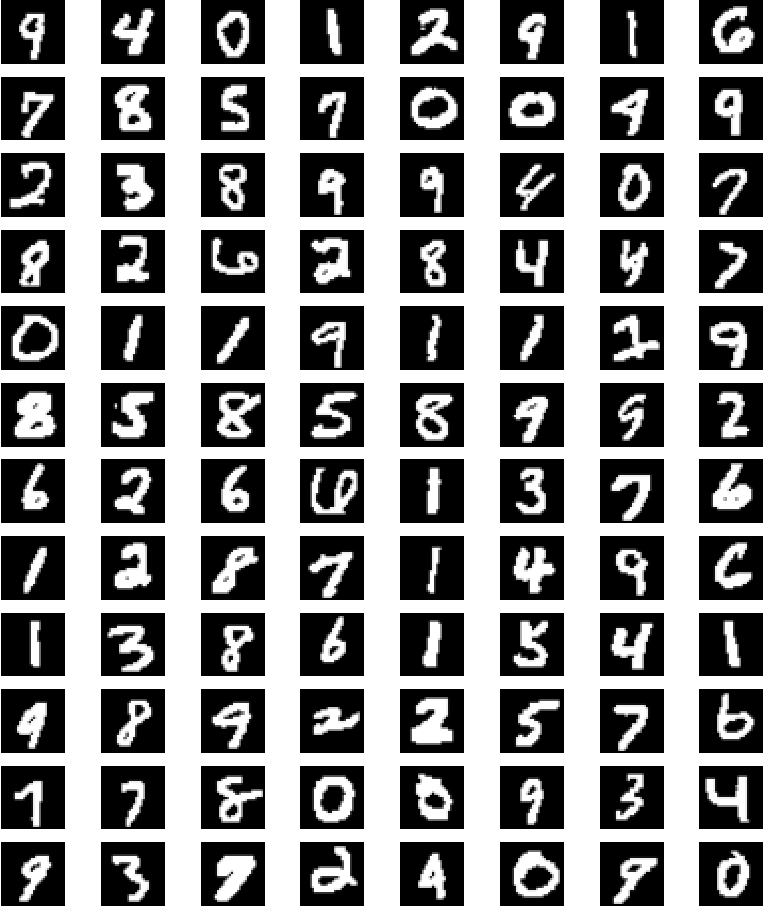

In [9]:
%matplotlib inline
plt.figure(figsize=(100.0, 120.0), dpi=10)
for j,images in enumerate(test_images):
    for i,image in enumerate(images):
        plt.subplot(12, 8, i+1+32*j)
        plt.subplots_adjust(wspace=0.3)
        image = np.squeeze(image, 0)
        image = image/np.amax(image)
        image = np.clip(image, 0, 1)
        plt.imshow(image, cmap='gray', interpolation='nearest')
        # plt.title(f"image {i+1}\nlabel:  {batch_label[i]}", y=-0.65, fontdict={"fontsize":8})
        plt.axis('off')   
print("Test images before attacking showed below:\n")
plt.show()

### 攻击模型

调用MindArmour提供的FGSM接口（`FastGradientSignMethod`），使用被攻击前抽取的96张数据图像`test_images`作为被攻击数据集，保存被攻击后数据集图像到当前notebook目录下的`ada_data`文件中。其中，参数`eps`为攻击对数据范围产生的单步对抗性摄动的比例，该值越大，则攻击程度越大。关于`FastGradientSignMethod`的详细使用说明，可参考[官方API文档](https://www.mindspore.cn/doc/api_python/zh-CN/master/mindarmour/mindarmour.adv_robustness.attacks.html#mindarmour.adv_robustness.attacks.FastGradientSignMethod)。

In [10]:
import time
from mindarmour.adv_robustness.attacks import FastGradientSignMethod


# attacking
attack = FastGradientSignMethod(net, eps=0.3)
start_time = time.perf_counter()
adv_data = attack.batch_generate(np.concatenate(test_images),
                                 np.concatenate(test_labels), batch_size=32)
stop_time = time.perf_counter()
np.save('./adv_data', adv_data)
print("The shape of adv_datas is :", adv_data.shape)

The shape of adv_datas is : (96, 1, 32, 32)


### 测试攻击后模型精度

对模型进行FGSM无目标攻击后，通过输出信息可以看到：

模型精度由97.9%降到5.2%，误分类率高达94.79%，成功攻击的对抗样本的预测类别的平均置信度（ACAC）为 0.716，成功攻击的对抗样本的真实类别的平均置信度（ACTC）为 0.056，同时给出了生成的对抗样本与原始样本的零范数距离、二范数距离和无穷范数距离，平均每个对抗样本与原始样本间的结构相似性为0.3327，平均每生成一张对抗样本所需时间为0.00139s。

In [11]:
from scipy.special import softmax
from mindarmour.adv_robustness.evaluations import AttackEvaluate


pred_logits_adv = model.predict(Tensor(adv_data)).asnumpy()
# rescale predict confidences into (0, 1).
pred_logits_adv = softmax(pred_logits_adv, axis=1)
pred_labels_adv = np.argmax(pred_logits_adv, axis=1)
accuracy_adv = np.mean(np.equal(pred_labels_adv, true_labels))
LOGGER.info(TAG, "prediction accuracy after attacking is : %s", accuracy_adv)
attack_evaluate = AttackEvaluate(np.concatenate(test_images).transpose(0, 2, 3, 1),
                                 np.concatenate(test_labels),
                                 adv_data.transpose(0, 2, 3, 1),
                                 pred_logits_adv)

LOGGER.info(TAG, 'mis-classification rate of adversaries is : %s',
            attack_evaluate.mis_classification_rate())
LOGGER.info(TAG, 'The average confidence of adversarial class is : %s',
            attack_evaluate.avg_conf_adv_class())
LOGGER.info(TAG, 'The average confidence of true class is : %s',
            attack_evaluate.avg_conf_true_class())
LOGGER.info(TAG, 'The average distance (l0, l2, linf) between original '
            'samples and adversarial samples are: %s',
            attack_evaluate.avg_lp_distance())
LOGGER.info(TAG, 'The average structural similarity between original '
            'samples and adversarial samples are: %s',
            attack_evaluate.avg_ssim())
LOGGER.info(TAG, 'The average costing time is %s',
            (stop_time - start_time)/(batch_num*batch_size))

[INFO] MA(2622:139980130522944,MainProcess):2020-12-01 16:56:15,382 [<ipython-input-11-bb318910a558>:10] [demo] prediction accuracy after attacking is : 0.052083333333333336
[INFO] MA(2622:139980130522944,MainProcess):2020-12-01 16:56:15,383 [<ipython-input-11-bb318910a558>:17] [demo] mis-classification rate of adversaries is : 0.9479166666666666
[INFO] MA(2622:139980130522944,MainProcess):2020-12-01 16:56:15,384 [<ipython-input-11-bb318910a558>:19] [demo] The average confidence of adversarial class is : 0.71637434
[INFO] MA(2622:139980130522944,MainProcess):2020-12-01 16:56:15,384 [<ipython-input-11-bb318910a558>:21] [demo] The average confidence of true class is : 0.056136377
[INFO] MA(2622:139980130522944,MainProcess):2020-12-01 16:56:15,391 [<ipython-input-11-bb318910a558>:24] [demo] The average distance (l0, l2, linf) between original samples and adversarial samples are: (1.5742399376497331, 0.44637327849144565, 0.3000000361557812)
[INFO] MA(2622:139980130522944,MainProcess):2020-

打印被攻击后的测试图像信息，由输出图像结果可以看出，被攻击后的图像和攻击前相比，成功误导了模型，使模型将其误分类为其他非正确类别。

Test images after attacking showed below:



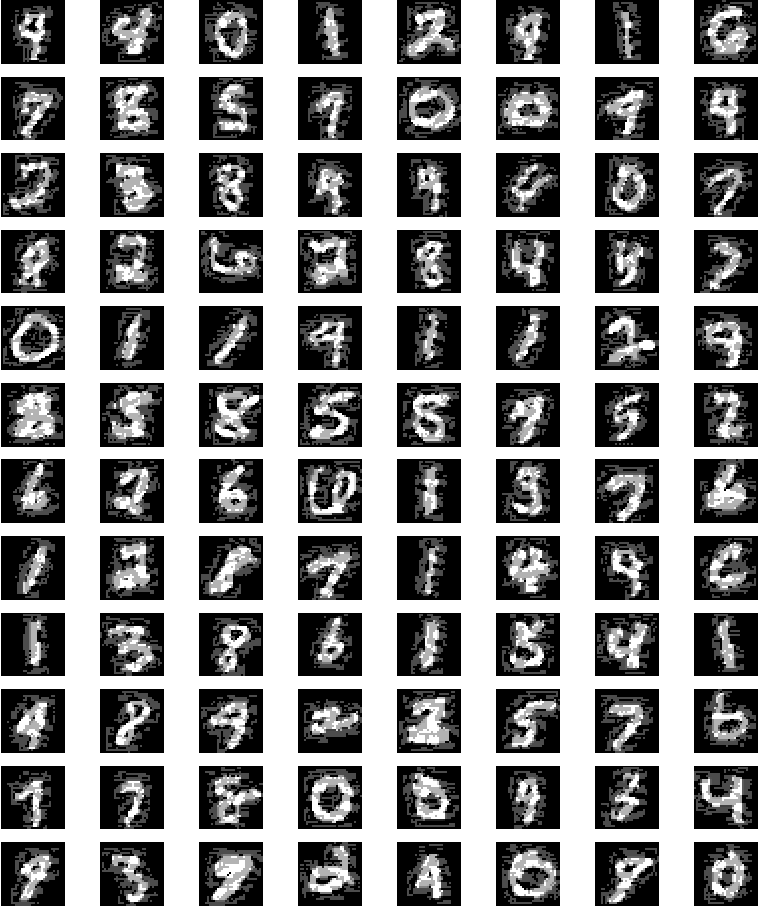

In [12]:
%matplotlib inline
plt.figure(figsize=(100.0, 120.0), dpi=10)
plt.set_cmap('binary')
for i,image in enumerate(adv_data):
    plt.subplot(12, 8, i+1)
    # plt.subplots_adjust(wspace=0.2, hspace=0.2)
    image = np.squeeze(image, 0)
    image = image/np.amax(image)
    image = np.clip(image, 0, 1)
    plt.imshow(image, cmap='gray', interpolation='nearest')
    plt.axis('off')   
print("Test images after attacking showed below:\n")
plt.show()

## 对抗性防御

`NaturalAdversarialDefense`（NAD）是一种简单有效的对抗样本防御方法，使用对抗训练的方式，在模型训练的过程中构建对抗样本，并将对抗样本与原始样本混合，一起训练模型。随着训练次数的增加，模型在训练的过程中提升对于对抗样本的鲁棒性。NAD算法使用FGSM作为攻击算法，构建对抗样本。

### 防御实现

调用MindArmour提供的NAD防御接口（`NaturalAdversarialDefense`）。

In [13]:
from mindspore.nn import SoftmaxCrossEntropyWithLogits
from mindarmour.adv_robustness.defenses import NaturalAdversarialDefense


loss = SoftmaxCrossEntropyWithLogits(sparse=False, reduction='mean')
opt = nn.Momentum(net.trainable_params(), 0.01, 0.09)

nad = NaturalAdversarialDefense(net, loss_fn=loss, optimizer=opt,
                                bounds=(0.0, 1.0), eps=0.3)
net.set_train()
nad.batch_defense(np.concatenate(test_images), np.concatenate(test_labels),
                  batch_size=32, epochs=20)

# get accuracy of test data on defensed model
net.set_train(False)
acc_list = []
pred_logits_adv = []
for i in range(batch_num):
    batch_inputs = test_images[i]
    batch_labels = test_labels[i]
    logits = net(Tensor(batch_inputs)).asnumpy()
    pred_logits_adv.append(logits)
    label_pred = np.argmax(logits, axis=1)
    acc_list.append(np.mean(np.argmax(batch_labels, axis=1) == label_pred))
pred_logits_adv = np.concatenate(pred_logits_adv)
pred_logits_adv = softmax(pred_logits_adv, axis=1)

LOGGER.info(TAG, 'accuracy of TEST data on defensed model is : %s',
             np.mean(acc_list))
acc_list = []
for i in range(batch_num):
    batch_inputs = adv_data[i * batch_size: (i + 1) * batch_size]
    batch_labels = test_labels[i]
    logits = net(Tensor(batch_inputs)).asnumpy()
    label_pred = np.argmax(logits, axis=1)
    acc_list.append(np.mean(np.argmax(batch_labels, axis=1) == label_pred))

attack_evaluate = AttackEvaluate(np.concatenate(test_images),
                                 np.concatenate(test_labels),
                                 adv_data,
                                 pred_logits_adv)

LOGGER.info(TAG, 'accuracy of adv data on defensed model is : %s',
            np.mean(acc_list))
LOGGER.info(TAG, 'defense mis-classification rate of adversaries is : %s',
            attack_evaluate.mis_classification_rate())
LOGGER.info(TAG, 'The average confidence of adversarial class is : %s',
            attack_evaluate.avg_conf_adv_class())
LOGGER.info(TAG, 'The average confidence of true class is : %s',
            attack_evaluate.avg_conf_true_class())
LOGGER.info(TAG, 'The average distance (l0, l2, linf) between original '
            'samples and adversarial samples are: %s',
            attack_evaluate.avg_lp_distance())


[INFO] MA(2622:139980130522944,MainProcess):2020-12-01 16:56:20,485 [<ipython-input-13-065f75174bd9>:29] [demo] accuracy of TEST data on defensed model is : 1.0
[INFO] MA(2622:139980130522944,MainProcess):2020-12-01 16:56:20,498 [<ipython-input-13-065f75174bd9>:44] [demo] accuracy of adv data on defensed model is : 0.3645833333333333
[INFO] MA(2622:139980130522944,MainProcess):2020-12-01 16:56:20,498 [<ipython-input-13-065f75174bd9>:46] [demo] defense mis-classification rate of adversaries is : 0.0
[INFO] MA(2622:139980130522944,MainProcess):2020-12-01 16:56:20,499 [<ipython-input-13-065f75174bd9>:48] [demo] The average confidence of adversarial class is : 0
[INFO] MA(2622:139980130522944,MainProcess):2020-12-01 16:56:20,499 [<ipython-input-13-065f75174bd9>:50] [demo] The average confidence of true class is : 0
[INFO] MA(2622:139980130522944,MainProcess):2020-12-01 16:56:20,500 [<ipython-input-13-065f75174bd9>:53] [demo] The average distance (l0, l2, linf) between original samples and 

### 防御效果

通过输出信息可以看出，使用NAD进行对抗样本防御后，模型对于对抗样本的误分类率从94.79%降至0，模型有效地防御了对抗样本。同时，模型对于原来测试数据集的分类精度达100%，使用NAD防御功能，并未降低模型的分类精度。

## 总结

以上便完成了MindArmour在模型安全上的应用体验，我们通过本次体验理解了对模型攻击的概念和原理，了解了如何使用`FastGradientSignMethod`接口对模型攻击和`NaturalAdversarialDefense`接口实现对抗性防御。